<a href="https://colab.research.google.com/github/Topolewski-Kamil/information_retrieval/blob/master/robot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SARSA and Q-learning algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# return an e-greedy action
def e_greedy_action(eps, Q, N_actions):
  greedy = (np.random.rand() > eps)  # use greedy with 1-e probability
  if greedy:
      action = np.argmax(Q)  # pick greedy action
  else:
      action = np.random.randint(N_actions) # pick random action
  return action

# update weights based on algorithm
def weights_future_reward(Q, Q_new, action, action_new, learning_rate, r, algorithm, output, x):
  if algorithm == 'qlearning':
    action_new2 = np.argmax(Q_new)                           #pick best actioN
    dw = learning_rate * (r - Q[action] + gamma * Q_new[action_new2]) * np.outer(output, x)
  elif algorithm == 'sarsa': 
    dw = learning_rate * (r - Q[action] + gamma * Q_new[action_new]) * np.outer(output, x)
  return dw

def homing_nn(n_trials, n_steps, learning_rate, eps, gamma, policy, algorithm):
    ## Definition of the environment
    N = 4     # height of the gridworld 
    M = 12    # length of the gridworld 
    N_states = N * M  # total number of states
    
    # Initialise a matrix where each row is one of the possible state vectors.
    states_matrix = np.eye(N_states)

    # 4 possible actions to move to each adjacent square
    N_actions = 4                                           
    action_change = np.array( [ [ 0, +1],
                                [+1, 0],
                                [ 0, -1],
                                [-1, 0]])
    action_labels = ['Right', 'Down', 'Left', 'Up'] 
    
    End = np.array([0, 11])   #terminal state
    s_end = np.ravel_multi_index(End, dims=(N, M), order='F')  #terminal state. Conversion in single index

    # initialize cliff indexes
    cliff = [4,8,12,16,20,24,28,32,36,40]

    # initiliazed weights to 0.0
    weights = np.random.rand(N_actions, N_states)*0.0

    # learning curve
    learning_curve = np.zeros((n_trials))
    
    # total rewards for each trail
    Rewards = np.zeros((1,nTrials))

    # array storing states visited
    routes = []

    # Start trials
    for trial in range(n_trials):

        Start = np.array([0,0]) # start at state (0,0)
        s_start = np.ravel_multi_index(Start, dims=(N,M), order='F')  # conversion in single index

        routes.append(s_start) # append start state to routes

        state = Start  # set current state
        s_index = s_start   #conversion in single index

        x = states_matrix[s_index]  # convert the state into an input vector     
        
        Q = np.matmul(weights, x) # calculate current Q-value using a neural network

        # for the first trial pick random
        if trial == 0:
          action = np.random.randint(N_actions)
        # for the rest according to policy
        else:
          # pick action based on e-greedy policy
          if policy == 'e-greedy':
            action = e_greedy_action(eps, Q, N_actions)

        # the output array (1 where action was taken, 0 otherwise)
        output = np.zeros((N_actions))                     
        output[action] = 1
        
        # Begin steps iteration 
        for step in range(n_steps):
            
            learning_curve[trial] = step + 1 # Keep track of the current number of steps taken
            state_new = state + action_change[action] # Apply selected action to move to give a new state
            
            #put the robot back in grid if it goes out. Consider also the option to give a negative reward
            if state_new[0] < 0:
                state_new[0] = 0
            if state_new[0] >= N:
                state_new[0] = N-1
            if state_new[1] < 0:
                state_new[1] = 0
            if state_new[1] >= M:
                state_new[1] = M-1
            
            # Convert the new position into an index
            s_index_new = np.ravel_multi_index(state_new, dims=(N,M), order='F')

            routes.append(s_index_new)
                        
            # if agent reaches the final tile
            if (s_index_new == s_end):
                r = 0 # final state has a reward of 0
                
                x_new = states_matrix[s_index_new] # convert the state into an input vector (S')

                # Calculate the weight update with the immediate reward
                dw = learning_rate * (r - Q[action]) * np.outer(output, x)
                weights += dw
                break

            # if agent reaches the cliff tile
            elif s_index_new in cliff:
                r = -100 # cliff has a reward -100

                # convert the state into an input vector (S')
                x_new = states_matrix[s_index_new]
                
                # Calculate the weight update with the immediate reward
                dw = learning_rate * (r - Q[action]) * np.outer(output, x)
                weights += dw

                # Store reward
                Rewards[0,trial] += r 
                break

            # Otherwise it is a normal step and we can need to select the next actions
            else:
                r = -1 # normal tile has reward-1

                # Store reward
                Rewards[0,trial] += r 

                # convert the state into an input vector (S')
                x_new = states_matrix[s_index_new]
                
                # Predict the new Q-values
                Q_new = np.matmul(weights, x_new)
                
                #eps-greedy policy implementation
                if policy == 'e-greedy':
                  action_new = e_greedy_action(eps, Q_new, N_actions)
                
                # update according to future expected rewards and algorithm
                dw = weights_future_reward(Q, Q_new, action, action_new, learning_rate, r, algorithm, output, x)

                output_new = np.zeros((N_actions))
                output_new[action_new] = 1
                
                weights += dw
            
            # Replace the old values with the new ones ready for the next step
            state = np.copy(state_new)
            action = np.copy(action_new)
            Q = np.copy(Q_new)
            output = np.copy(output_new)
            x = np.copy(x_new)
            s_index = s_index_new

    return learning_curve, Rewards, routes

#### Call the SARSA and Q-learning function


In [2]:
# Parameter setup
nRepetitions = 10;   # number of runs for the algorithm
nTrials = 500;      # should be integer >0
nSteps = 100;        # maximum number of allowed steps
learningRate = 0.5; # should be real, Greater than 0
epsilon = 0.1;     # should be real, Greater or Equal to 0; epsion=0 Greedy, otherwise epsilon-Greedy
gamma = 1;        # should be real, positive, smaller than 1

### SARSA ###
# learning curves
learning_curvesE = np.zeros((nRepetitions, nTrials))
learning_curvesE2 = np.zeros((nRepetitions, nTrials))
learning_curvesE3 = np.zeros((nRepetitions, nTrials))
learning_curvesE4 = np.zeros((nRepetitions, nTrials))

# rewards
rewardsE = np.zeros((nRepetitions, nTrials))
rewardsE2 = np.zeros((nRepetitions, nTrials))
rewardsE3 = np.zeros((nRepetitions, nTrials))
rewardsE4 = np.zeros((nRepetitions, nTrials))

### Q-learning ###
learning_curvesQ = np.zeros((nRepetitions, nTrials)) # learning curve
rewardsQ = np.zeros((nRepetitions, nTrials)) #reward


# average number of steps to finish the task per trial for nRepetitions
for i in range(nRepetitions):
    np.random.seed(i) # seed for reproducing the rewards 

    ### SARSA ###
    learning_curvesE[i], rewardsE[i,:], routesE = homing_nn(nTrials, nSteps, learningRate, epsilon, gamma, 'e-greedy', 'sarsa')
    # learning_curvesE2[i], rewardsE2[i,:], routesE2 = homing_nn(nTrials, nSteps, learningRate, 0.0, gamma, 'e-greedy', 'sarsa') # eps=0.0
    # learning_curvesE3[i], rewardsE3[i,:], routesE3 = homing_nn(nTrials, nSteps, learningRate, 0.01, gamma, 'e-greedy', 'sarsa') # eps=0.01
    # learning_curvesE4[i], rewardsE4[i,:], routesE4 = homing_nn(nTrials, nSteps, learningRate, 0.2, gamma, 'e-greedy', 'sarsa') # eps=0.2

    ### Q-learning ###
    learning_curvesQ[i], rewardsQ[i,:], routesQ = homing_nn(nTrials, nSteps, learningRate, epsilon, gamma, 'e-greedy', 'qlearning')


Plot smoothed learning curves

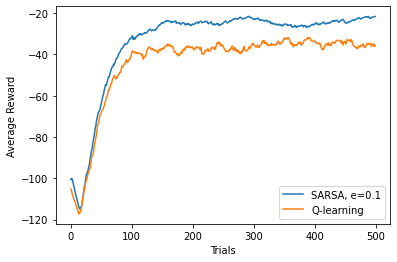

In [3]:
# smooth learning curve
def ema_smooth(rewards):
  tau = 0.05
  smooth_rewards = np.zeros((nRepetitions, nTrials))
  for i in range(nRepetitions):
    for j in range(nTrials):
      if j == 0:
        smooth_rewards[i,j] = rewards[i][j]
      else:
        smooth_rewards[i][j] = rewards[i][j] * tau + smooth_rewards[i][j-1]*(1-tau)
  return smooth_rewards

### SARSA ###
# eps 0.1
smooth_rewardsE = ema_smooth(rewardsE)
plt.plot(np.arange(nTrials), smooth_rewardsE.mean(axis=0), label = 'SARSA, e=0.1')

# eps 0.0
# smooth_rewardsE2 = ema_smooth(rewardsE2)
# plt.plot(np.arange(nTrials), smooth_rewardsE2.mean(axis=0), label = 'SARSA, e=0.0')

# eps 0.01
# smooth_rewardsE3 = ema_smooth(rewardsE3)
# plt.plot(np.arange(nTrials), smooth_rewardsE3.mean(axis=0), label = 'SARSA, e=0.01')

# eps 0.2
# smooth_rewardsE4 = ema_smooth(rewardsE4)
# plt.plot(np.arange(nTrials), smooth_rewardsE4.mean(axis=0), label = 'SARSA, e=0.2')

### Q-learning ###
smooth_rewardsQ = ema_smooth(rewardsQ)
plt.plot(np.arange(nTrials), smooth_rewardsQ.mean(axis=0), label = 'Q-learning')

# plot
plt.xlabel('Trials')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

Plot smoothed learning curves with standard error

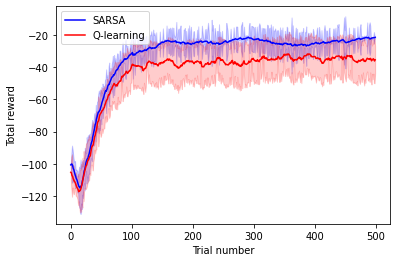

In [4]:
# Plot the average reward as a function of the number of trials --> the average has to be performed over the episodes

### SARSA ###
meansE = np.mean(smooth_rewardsE, axis = 0) # mean rewards
errorsE = np.std(rewardsE, axis = 0) / np.sqrt(nRepetitions) # standard error

### Q-learning ###
meansQ = np.mean(smooth_rewardsQ, axis = 0) # mean rewards
errorsQ = np.std(rewardsQ, axis = 0) / np.sqrt(nRepetitions) # standard error

# plot
x = np.arange(nTrials)
plt.plot(x, meansE, 'b-', label='SARSA', linewidth = 1.5,)
plt.fill_between(x, meansE - errorsE, meansE + errorsE, color='b', alpha=0.2)
plt.plot(x, meansQ, 'r-', label='Q-learning', linewidth = 1.5,)
plt.fill_between(x, meansQ - errorsQ, meansQ + errorsQ, color='r', alpha=0.2)
plt.xlabel('Trial number')
plt.ylabel('Total reward')
plt.legend()
plt.show()

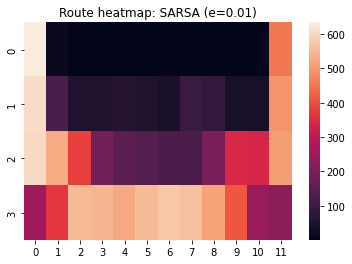

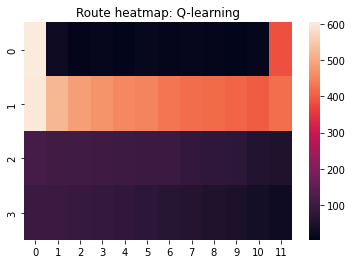

In [7]:
states_number = 48 # map size N x M

# Heat map of amount of times each state has been visited within all trails
def heatmap(routes, title):
  #count occurances of each state
  occurances = [] 
  for i in range(states_number):
    occurances.append(routes.count(i))
  
  # reshape and plot
  occurances = np.array(occurances).reshape(12,4)
  occurances = np.rot90(occurances)
  ax = sns.heatmap(np.flip(occurances, axis=0))
  ax.set_title(title)

### SARSA ###
heatmap(routesE, 'Route heatmap: SARSA (e=0.01)') # eps 0.1
plt.show()

# heatmap(routesE2, 'Route heatmap: SARSA (e=0.0)') # eps 0.0
# heatmap(routesE3, 'Route heatmap: SARSA (e=0.01)') # eps 0.01
# heatmap(routesE4, 'Route heatmap: SARSA (e=0.2)') # eps 0.2

### Q-learning ###
heatmap(routesQ, 'Route heatmap: Q-learning')
plt.show()

In [6]:
# plt.savefig('02.png', dpi=300)